In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'UBI.PA'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2015-03-31,980,-231,749,75,657,24,18,830,130,...,95,0,183,436,276,773,464,-28,113.29,2015-05-15
1,2015-09-30,207,-53,154,-75,273,27,50,472,125,...,108,0,159,376,275,714,-99,-24,114.19,2015-10-30
2,2016-03-31,1187,-252,935,169,461,420,19,1057,106,...,206,0,228,662,277,1002,440,-18,114.19,2016-05-15
3,2016-09-30,281,-55,226,-66,915,61,30,1130,106,...,104,0,243,527,634,1245,251,-27,119.67,2016-10-30
4,2017-03-31,1179,-216,963,174,853,406,25,1464,181,...,178,0,293,721,641,1448,394,-36,119.67,2017-05-15


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
15,2022-09-30,2022-10-30,121.14,731,-81,650,-190,1530,313,44,...,2069,5027,154,83,640,1645,1187,3240,452,-42
16,2023-03-31,2023-05-15,121.14,1083,-135,948,-305,1491,268,19,...,1776,4671,123,26,110,739,2062,3192,238,-30
17,2023-09-30,2023-10-30,147.34,836,-88,748,-35,1305,342,22,...,2004,4753,144,0,665,1283,1567,3174,219,-23
18,2024-03-31,2024-05-15,147.34,1465,-116,1349,192,1205,746,9,...,2075,5121,157,0,427,1057,2082,3242,319,-93
19,2024-09-30,2024-10-28,127.03,672,-90,582,-247,933,440,21,...,2183,4626,179,0,183,700,2158,2926,309,-20


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
15,2022-09-30,2022-10-30,121.14,731,-81,650,-190,1530,313,44,...,5027,154,83,640,1645,1187,3240,452,-42,0.992853
16,2023-03-31,2023-05-15,121.14,1083,-135,948,-305,1491,268,19,...,4671,123,26,110,739,2062,3192,238,-30,0.932003
17,2023-09-30,2023-10-30,147.34,836,-88,748,-35,1305,342,22,...,4753,144,0,665,1283,1567,3174,219,-23,0.918837
18,2024-03-31,2024-05-15,147.34,1465,-116,1349,192,1205,746,9,...,5121,157,0,427,1057,2082,3242,319,-93,0.920544
19,2024-09-30,2024-10-28,127.03,672,-90,582,-247,933,440,21,...,4626,179,0,183,700,2158,2926,309,-20,0.910617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
15,2022-09-30,2022-10-30,121.14,731,-81,650,-190,1530,313,44,...,5027,154,83,640,1645,1187,3240,452,-42,0.992853
16,2023-03-31,2023-05-15,121.14,1083,-135,948,-305,1491,268,19,...,4671,123,26,110,739,2062,3192,238,-30,0.932003
17,2023-09-30,2023-10-30,147.34,836,-88,748,-35,1305,342,22,...,4753,144,0,665,1283,1567,3174,219,-23,0.918837
18,2024-03-31,2024-05-15,147.34,1465,-116,1349,192,1205,746,9,...,5121,157,0,427,1057,2082,3242,319,-93,0.920544
19,2024-09-30,2024-10-28,127.03,672,-90,582,-247,933,440,21,...,4626,179,0,183,700,2158,2926,309,-20,0.910617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr, report='half-year')

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr, report='half-year')

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-05-18,16.495001,2015-03-31,980.0,0.0,8.641539,113.29,0.0,0.0,657.0,...,0.55879,0.44121,0.0,0.0,0.0,0.0,0.764286,0.076531,0.0,0.0
1,2015-05-25,16.440001,2015-03-31,980.0,0.0,8.641539,113.29,0.0,0.0,657.0,...,0.55879,0.44121,0.0,0.0,0.0,0.0,0.764286,0.076531,0.0,0.0
2,2015-06-01,15.950000,2015-03-31,980.0,0.0,8.641539,113.29,0.0,0.0,657.0,...,0.55879,0.44121,0.0,0.0,0.0,0.0,0.764286,0.076531,0.0,0.0
3,2015-06-08,16.424999,2015-03-31,980.0,0.0,8.641539,113.29,0.0,0.0,657.0,...,0.55879,0.44121,0.0,0.0,0.0,0.0,0.764286,0.076531,0.0,0.0
4,2015-06-15,15.670000,2015-03-31,980.0,0.0,8.641539,113.29,0.0,0.0,657.0,...,0.55879,0.44121,0.0,0.0,0.0,0.0,0.764286,0.076531,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr, report='half-year')
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-05-18,16.495001,2015-03-31,980.0,0.0,8.641539,113.29,0.0,0.0,657.0,...,0.0,0.764286,0.076531,0.0,0.0,inf,1.908804,inf,inf,inf
1,2015-05-25,16.440001,2015-03-31,980.0,0.0,8.641539,113.29,0.0,0.0,657.0,...,0.0,0.764286,0.076531,0.0,0.0,inf,1.902439,inf,inf,inf
2,2015-06-01,15.950000,2015-03-31,980.0,0.0,8.641539,113.29,0.0,0.0,657.0,...,0.0,0.764286,0.076531,0.0,0.0,inf,1.845736,inf,inf,inf
3,2015-06-08,16.424999,2015-03-31,980.0,0.0,8.641539,113.29,0.0,0.0,657.0,...,0.0,0.764286,0.076531,0.0,0.0,inf,1.900703,inf,inf,inf
4,2015-06-15,15.670000,2015-03-31,980.0,0.0,8.641539,113.29,0.0,0.0,657.0,...,0.0,0.764286,0.076531,0.0,0.0,inf,1.813334,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

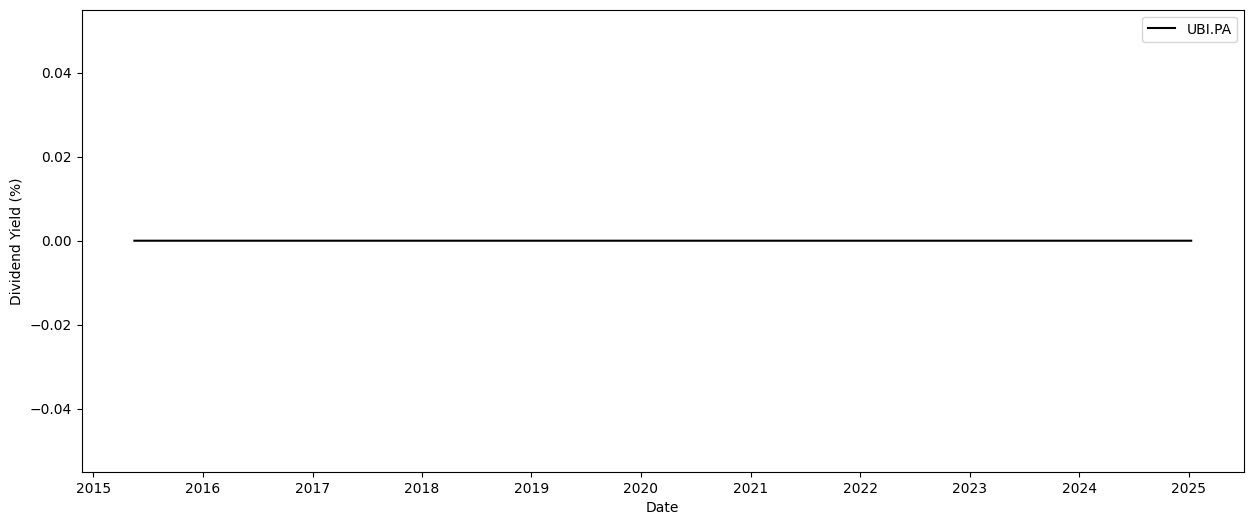

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.615604
share_price      1.000000
Name: share_price, dtype: float64


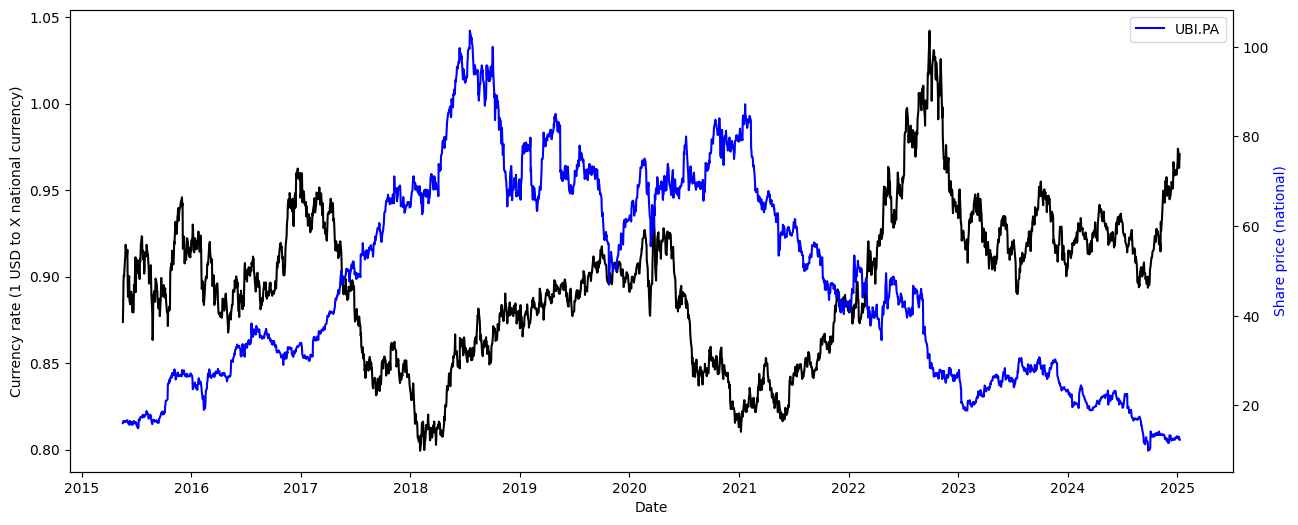

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

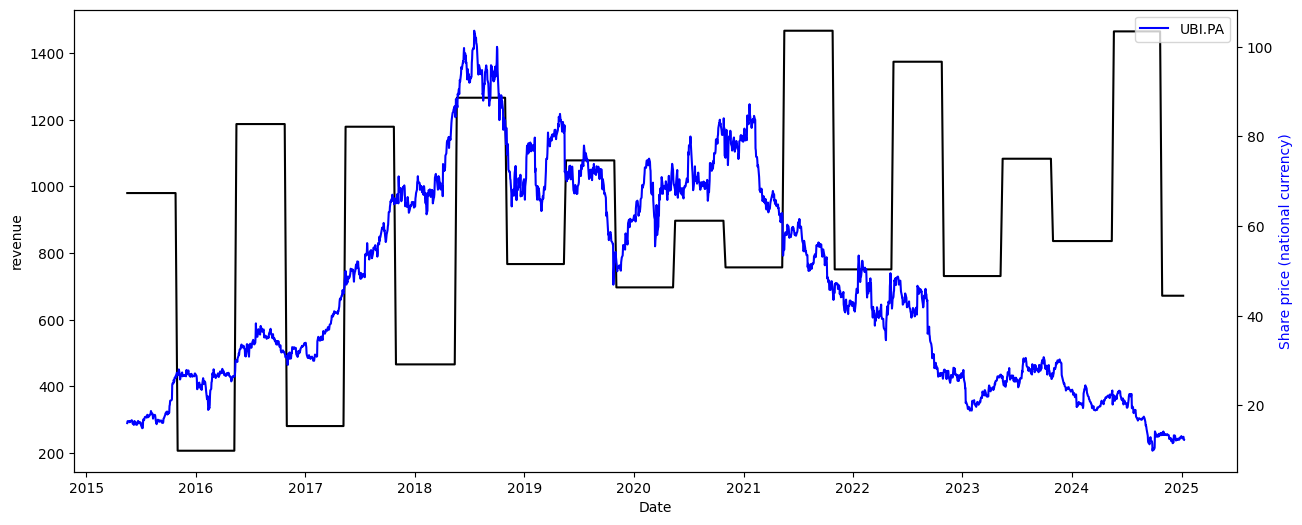

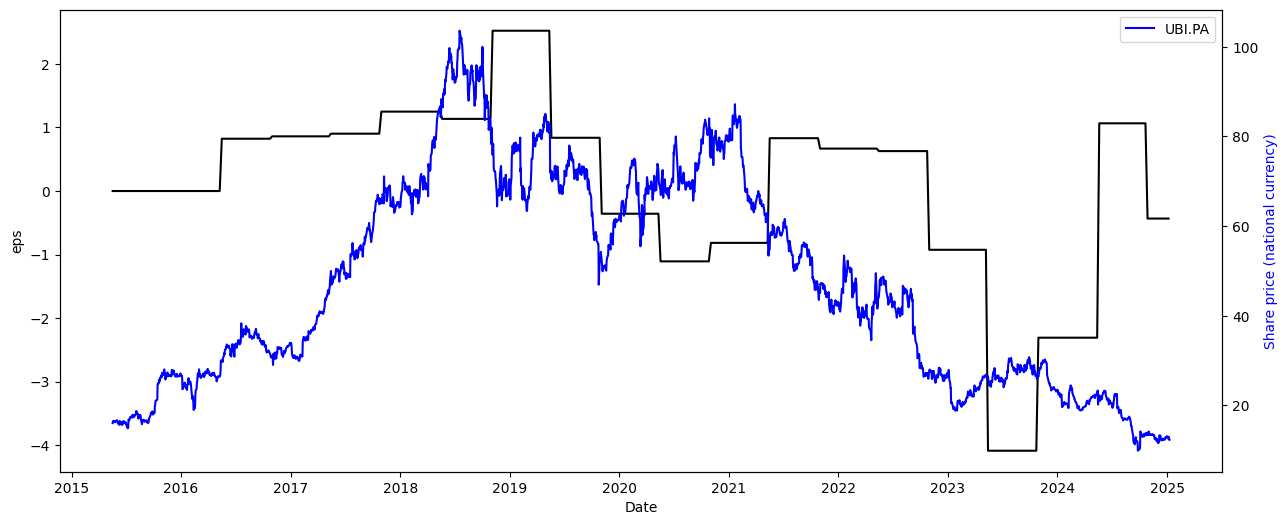

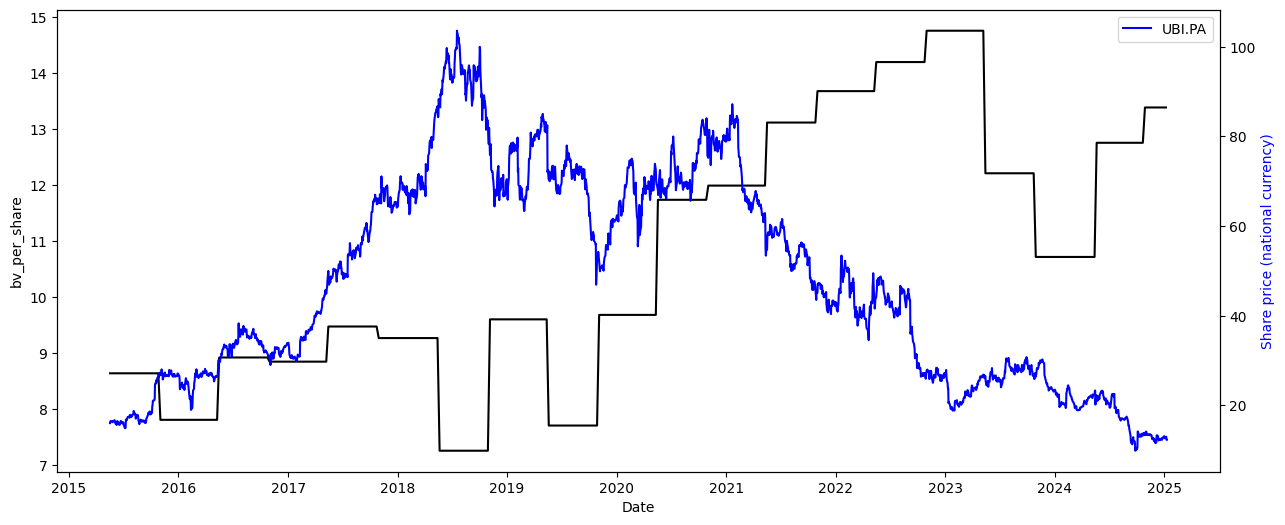

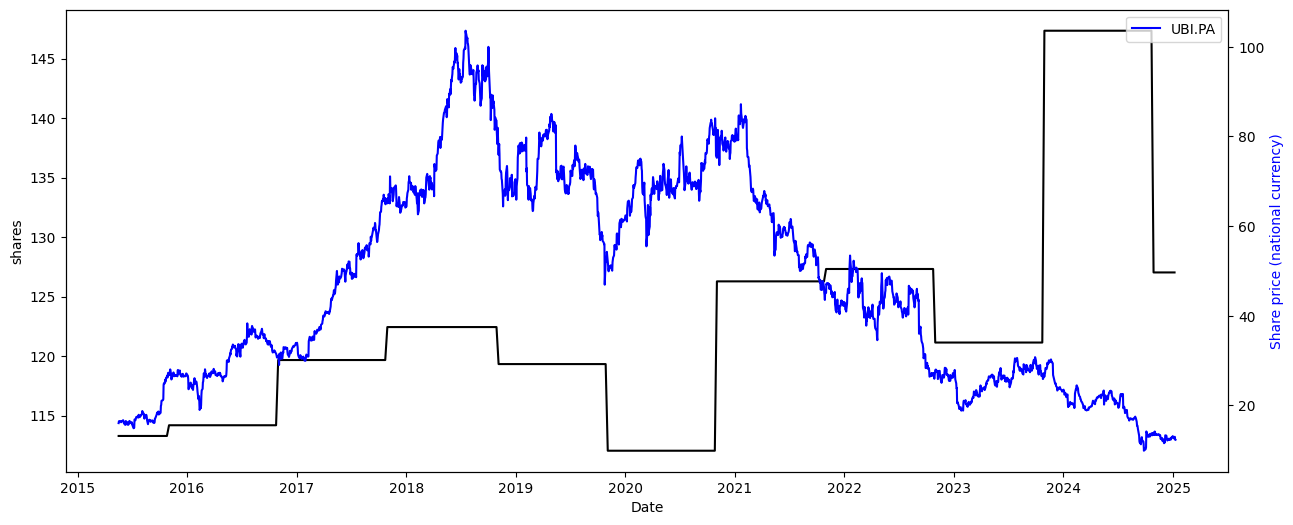

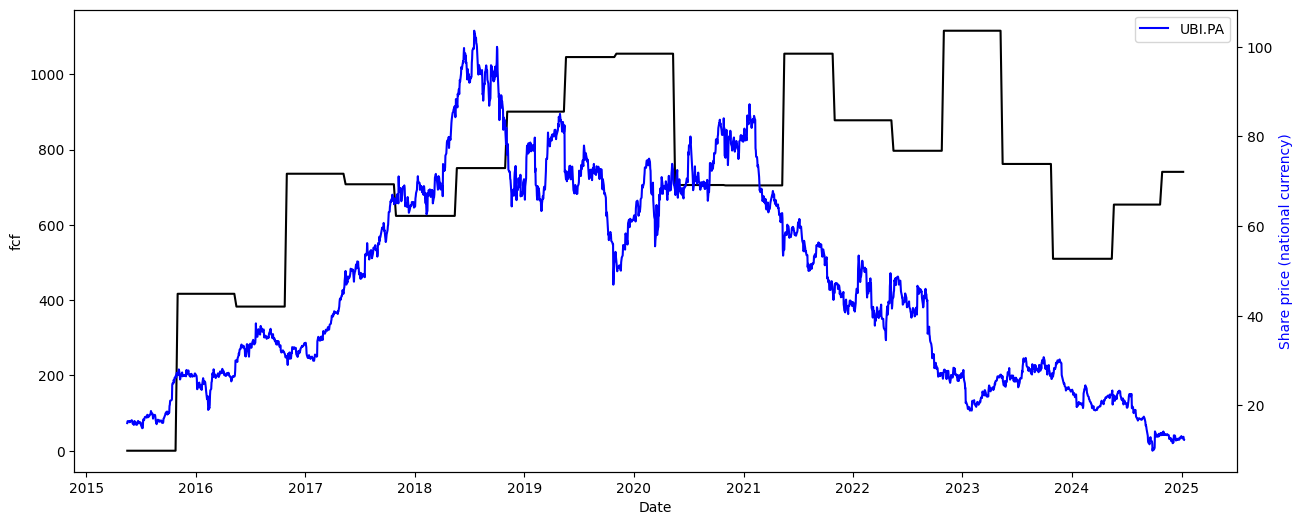

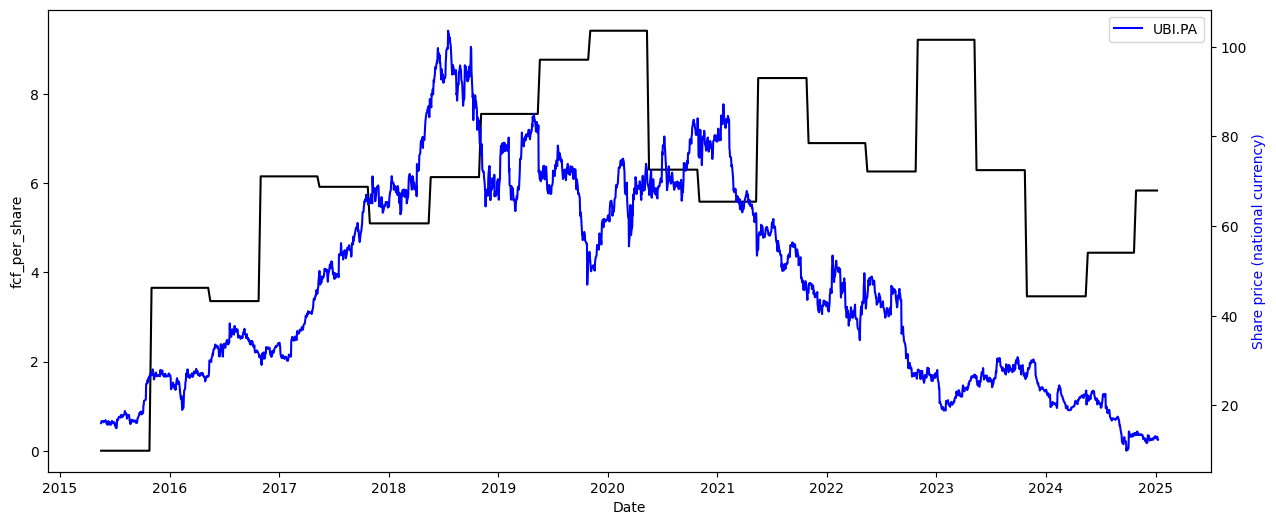

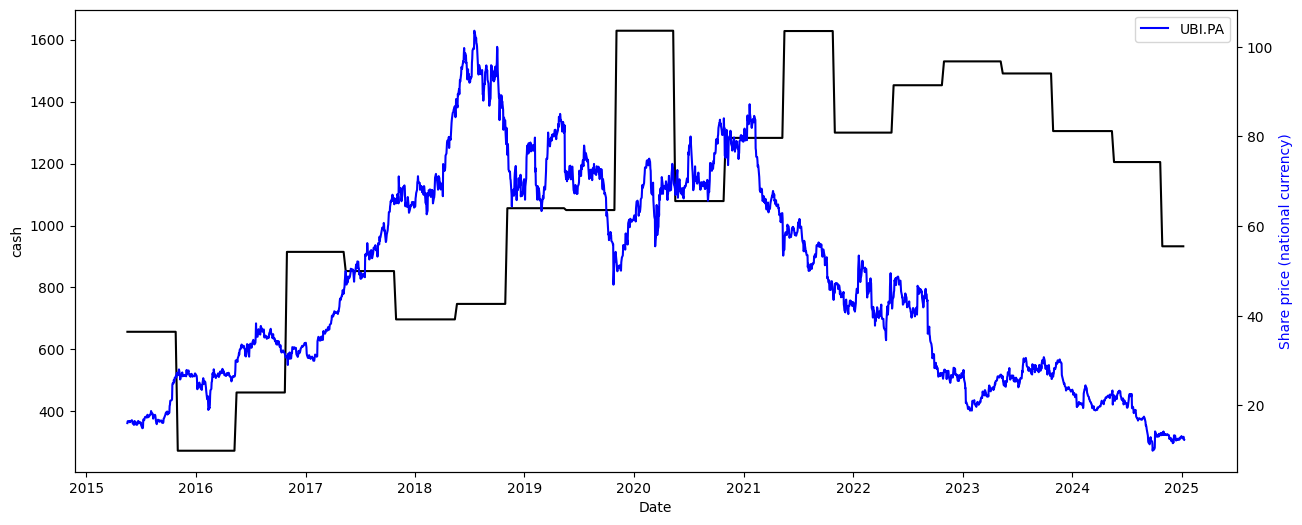

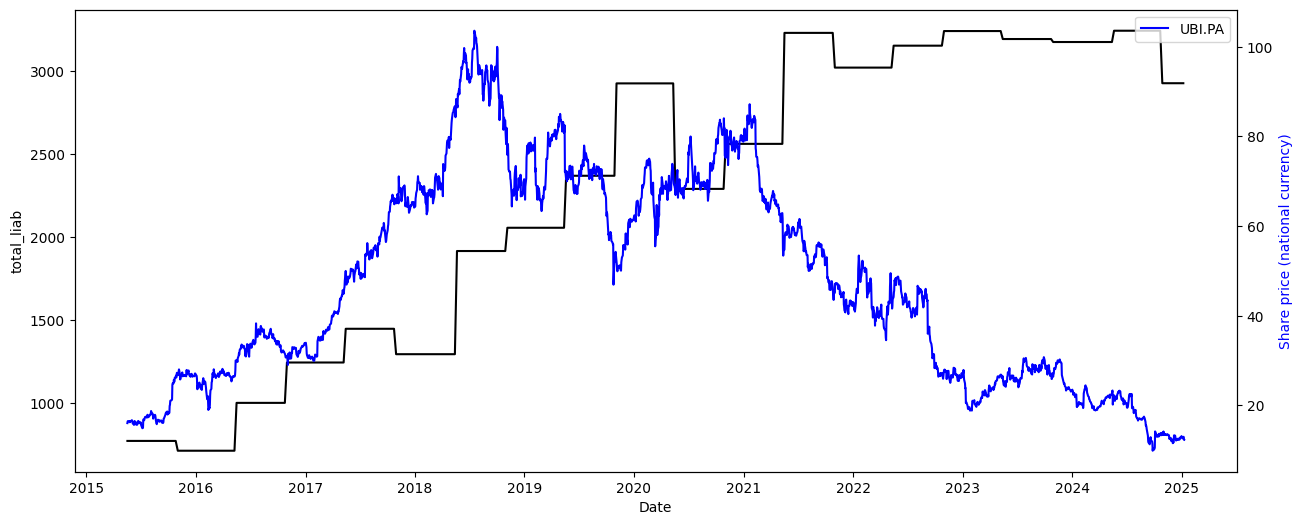

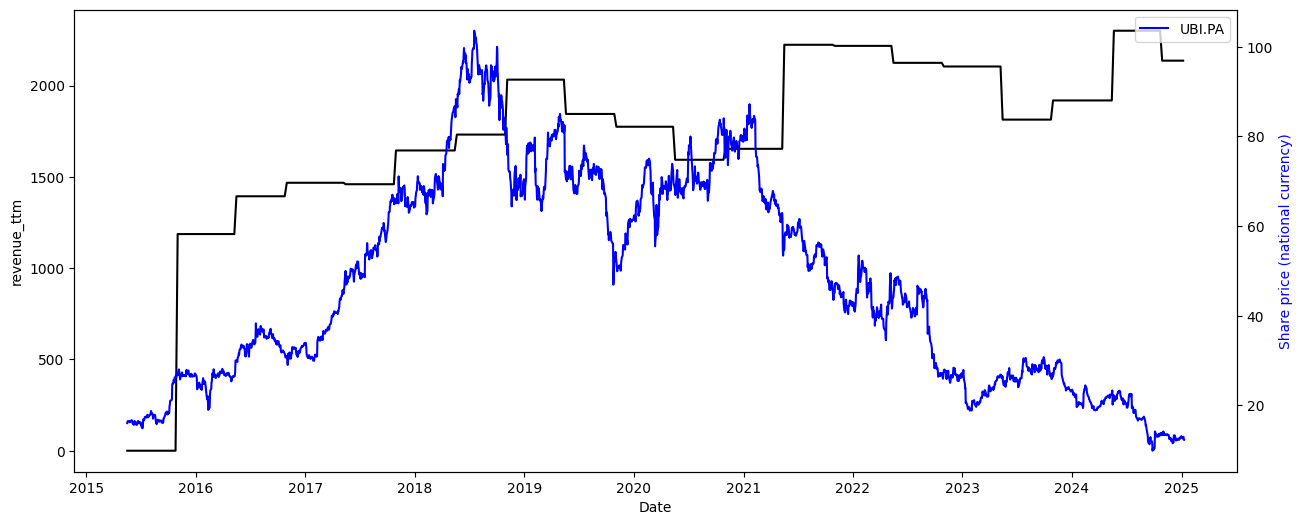

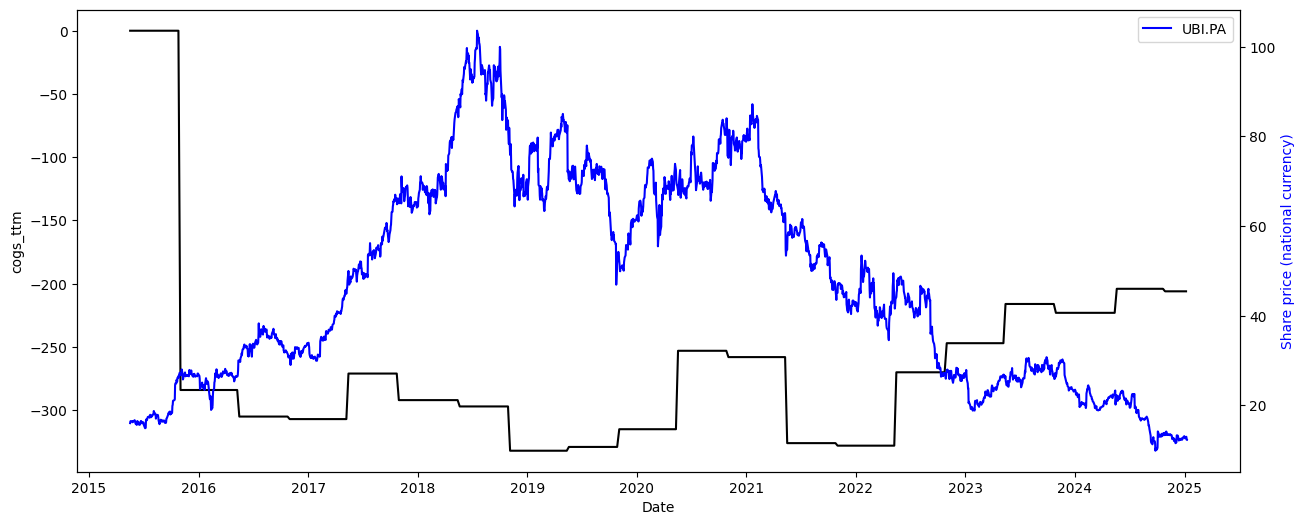

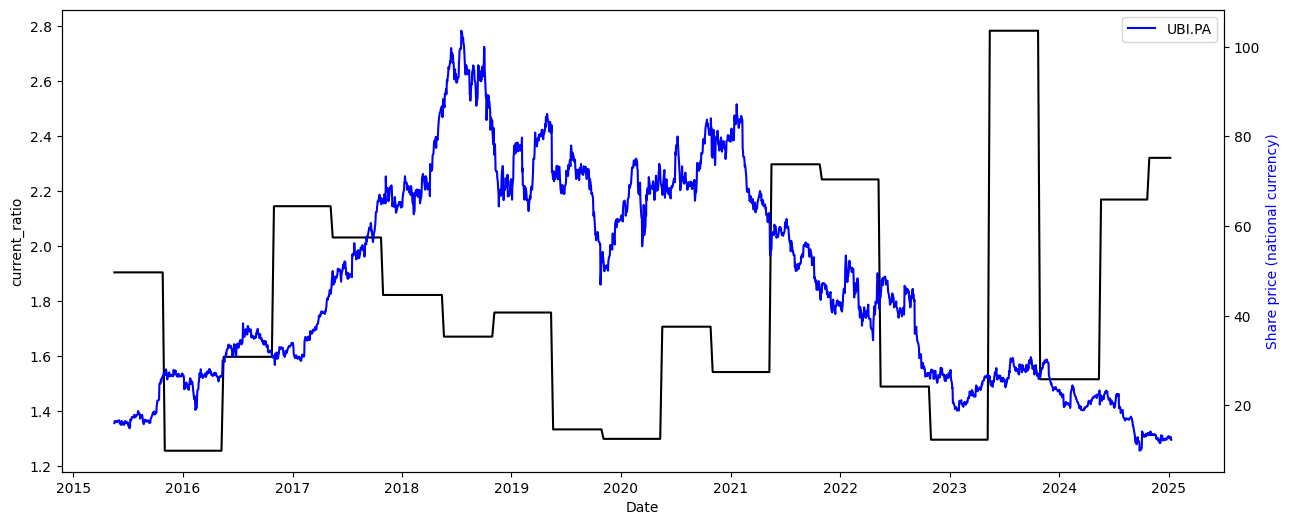

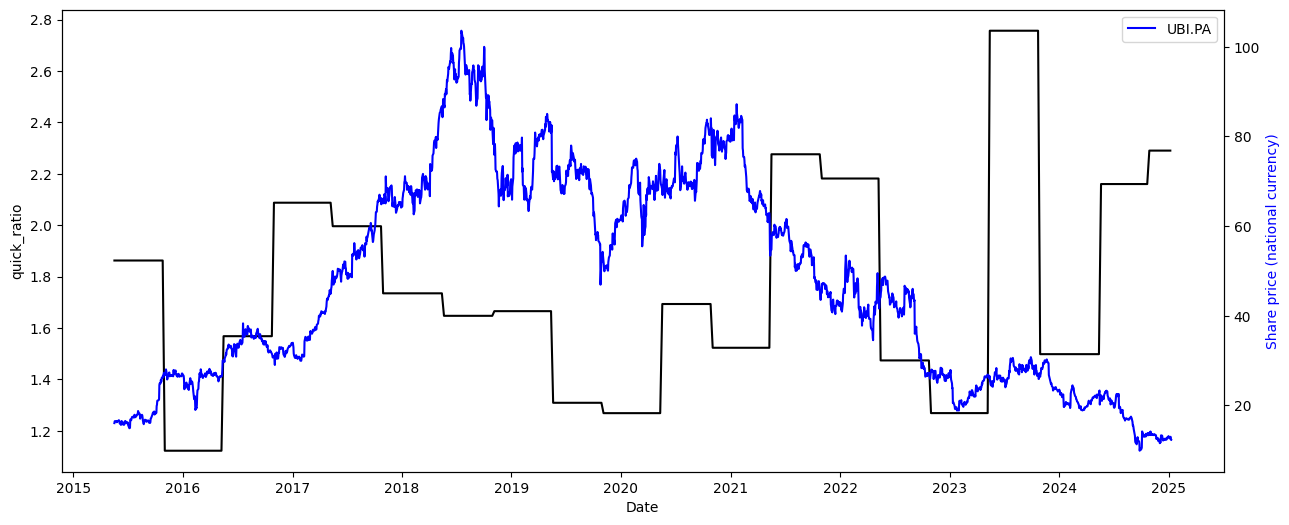

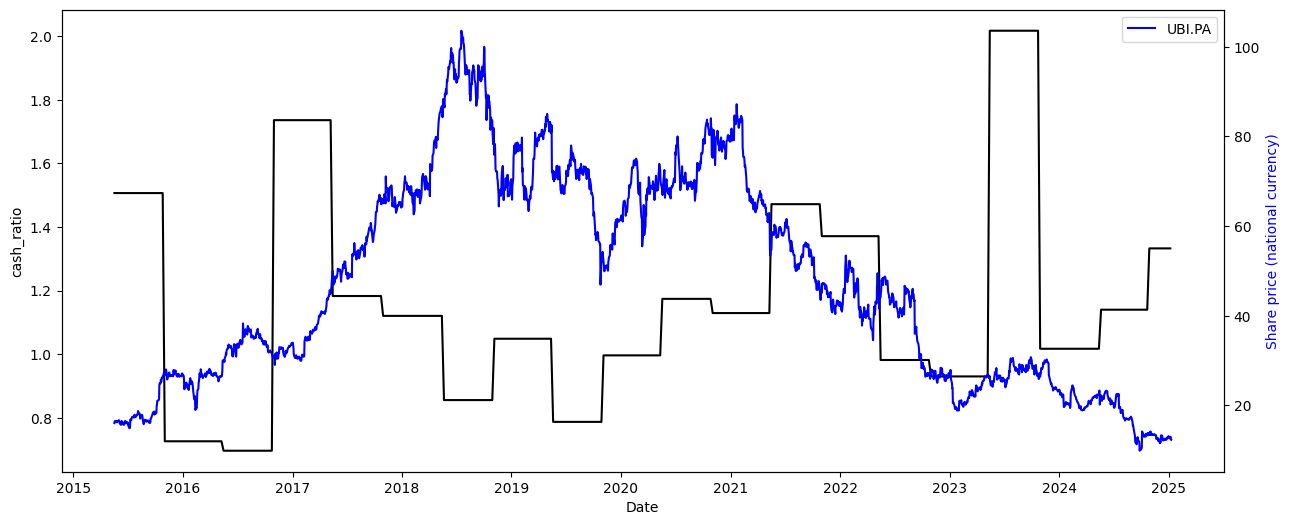

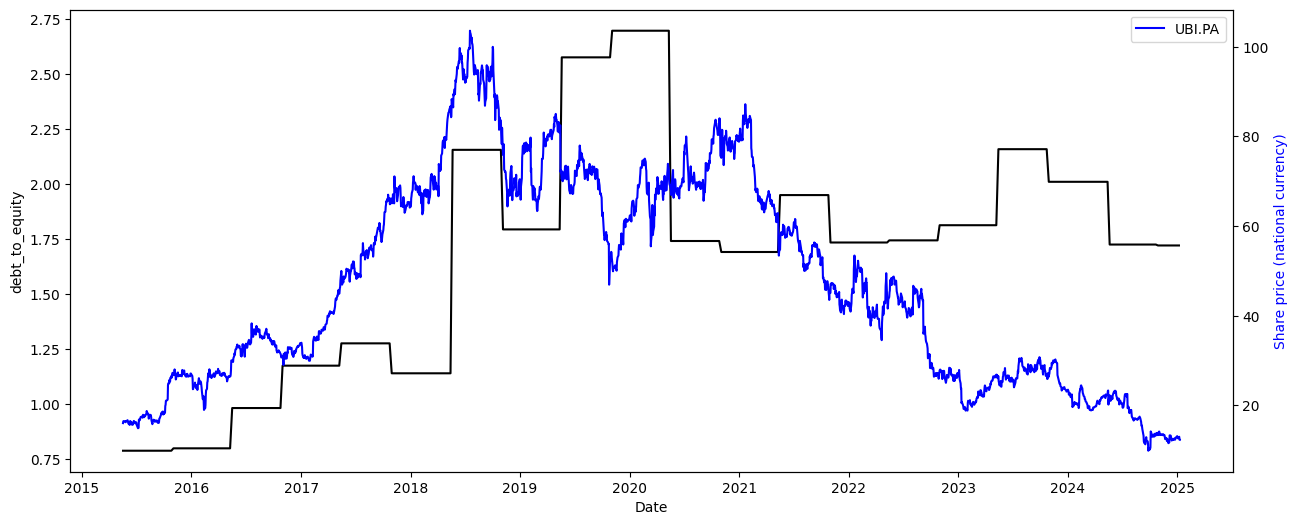

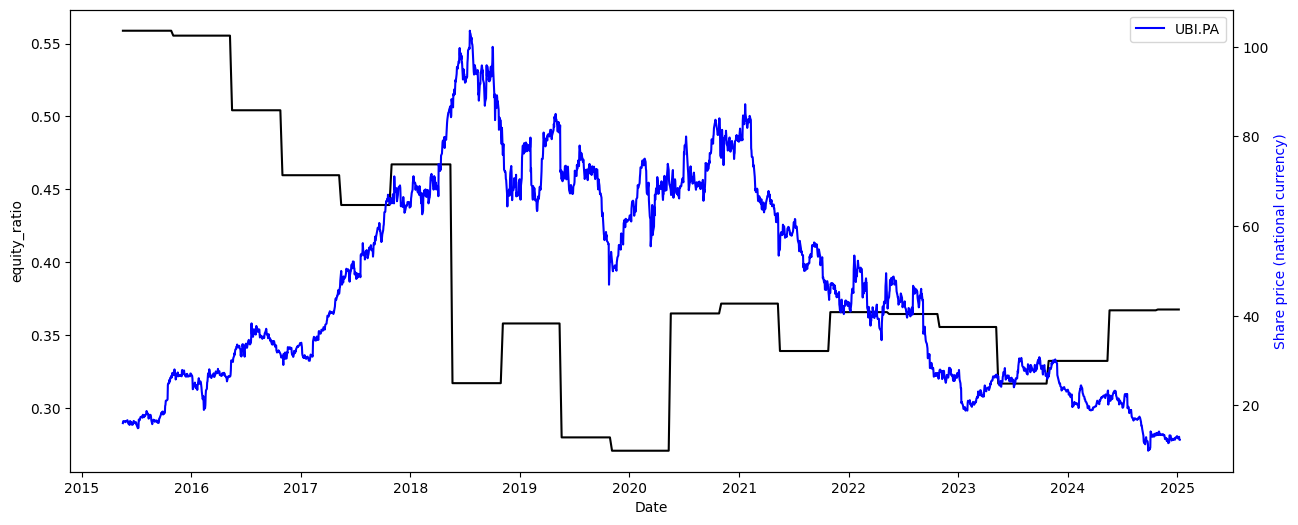

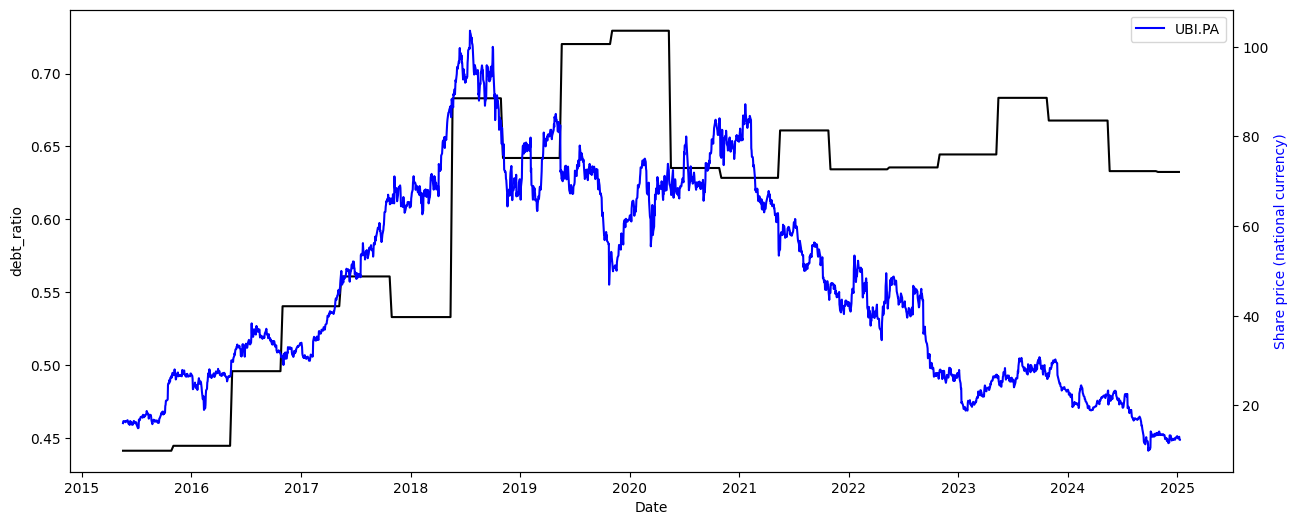

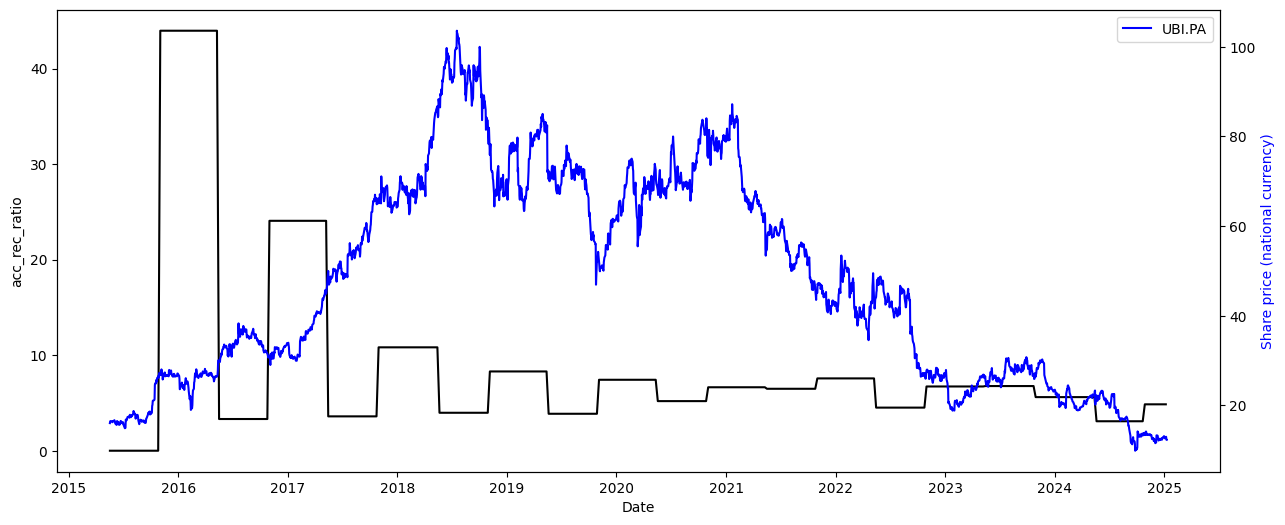

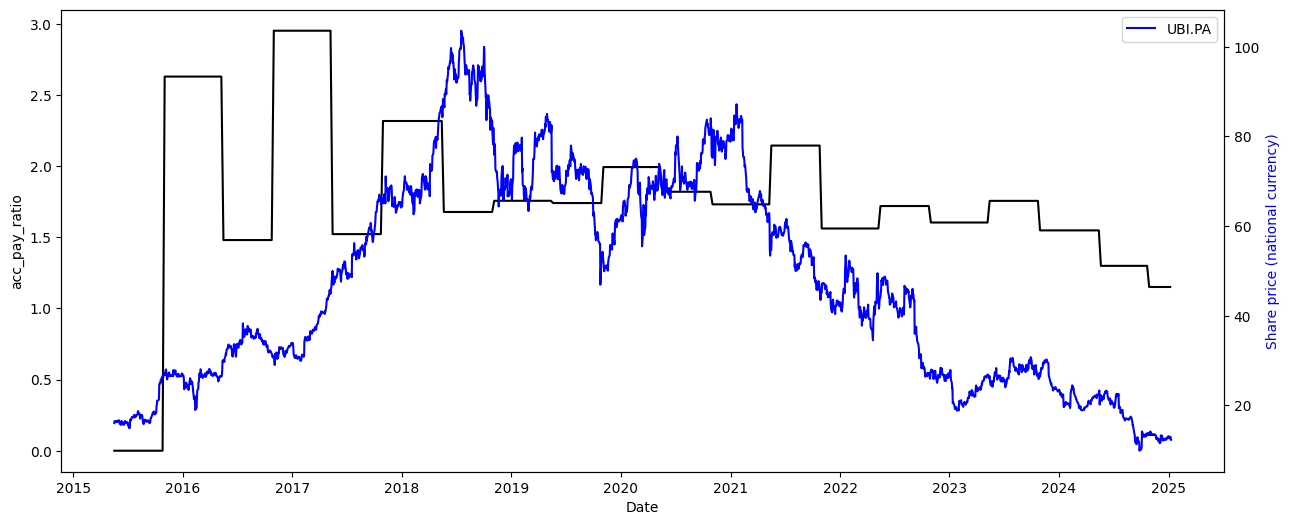

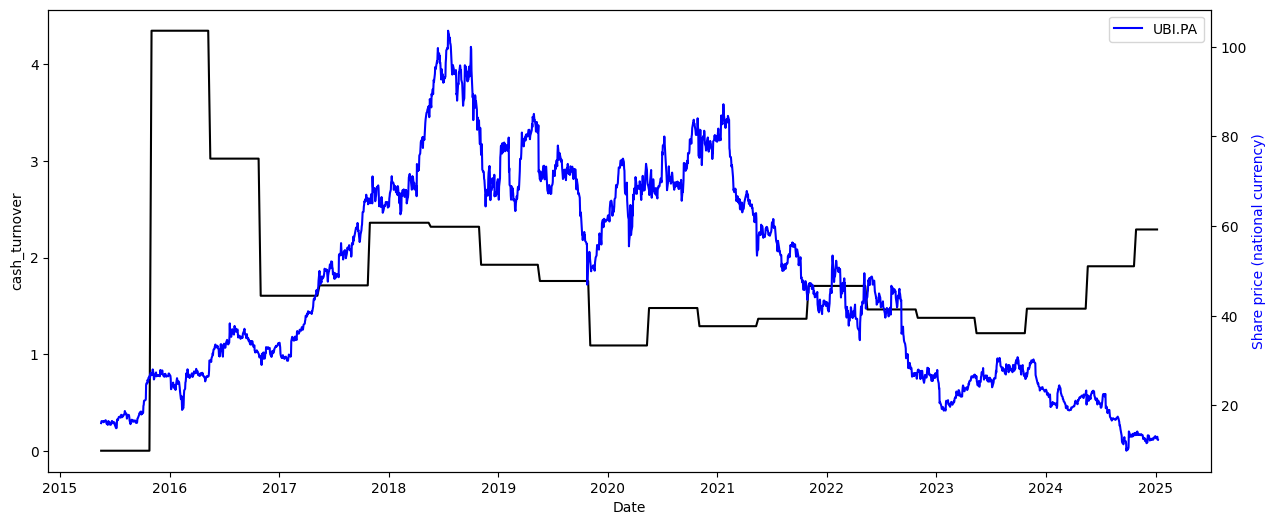

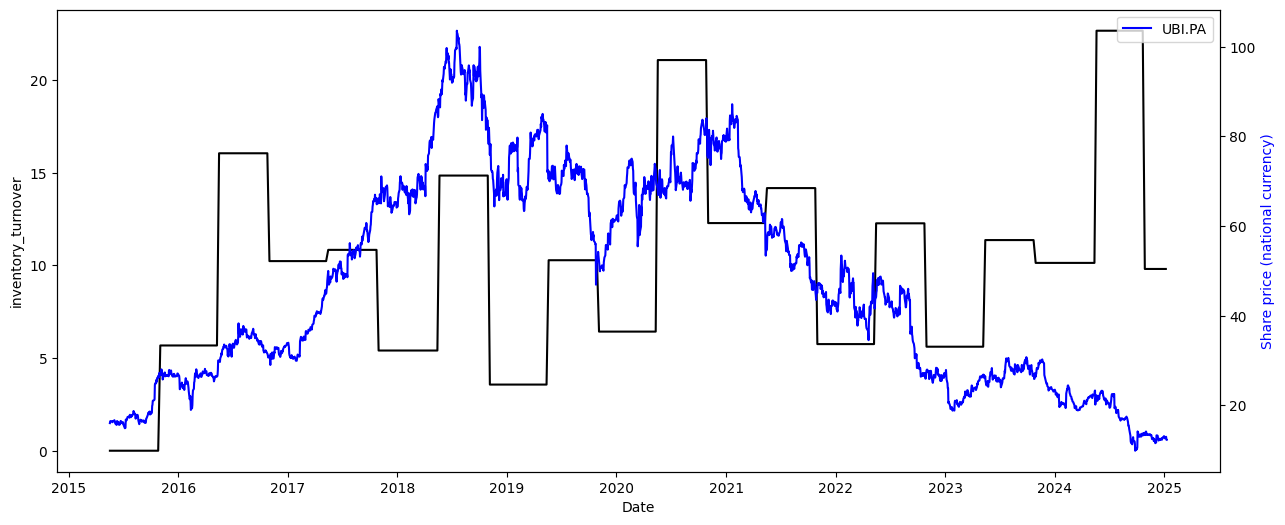

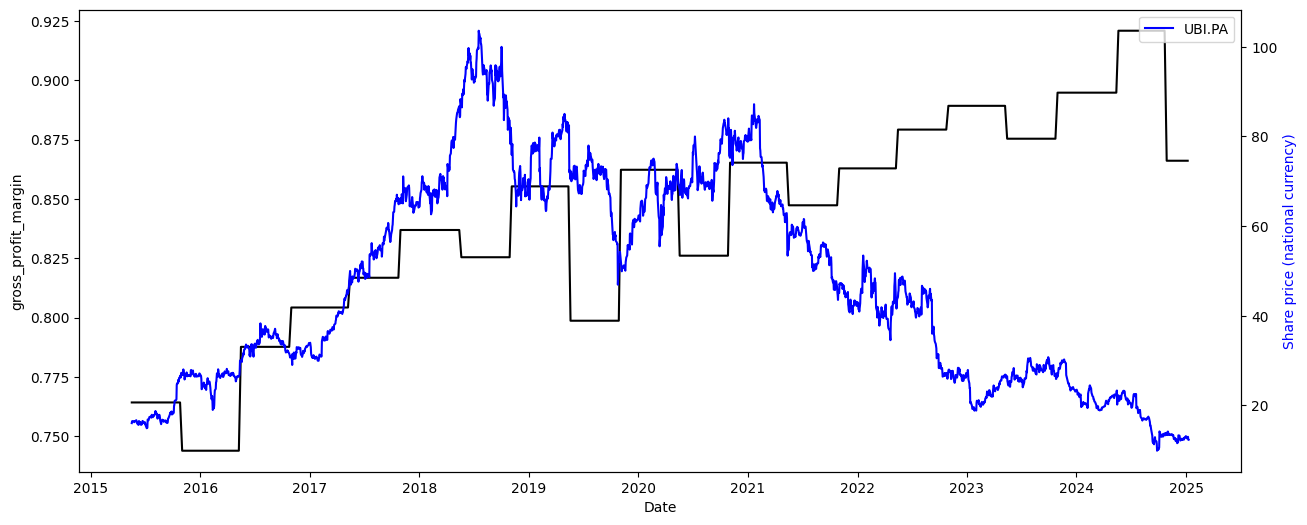

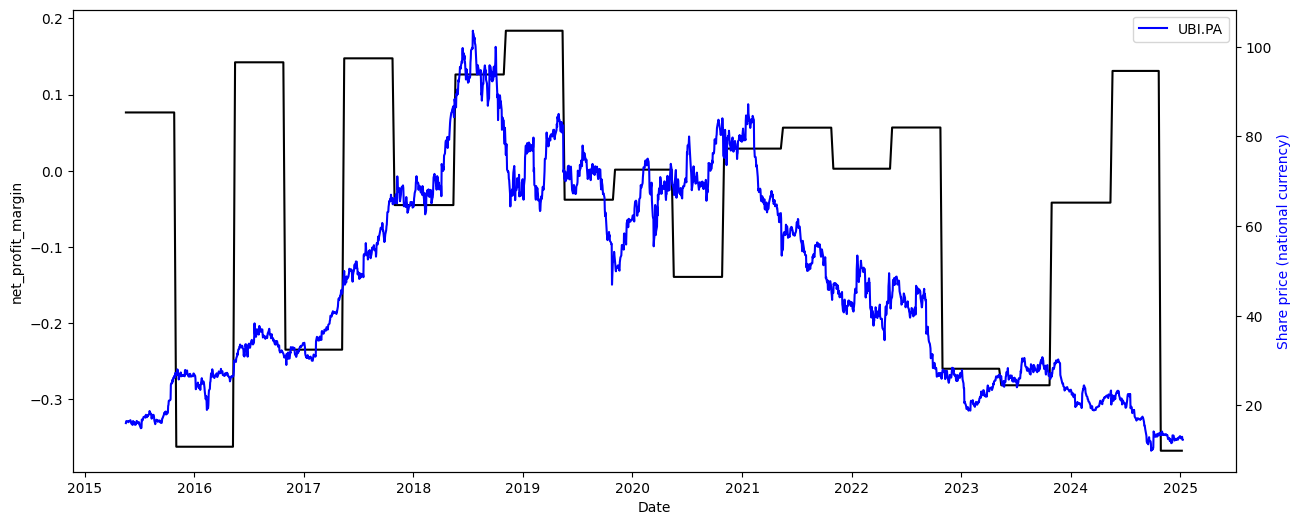

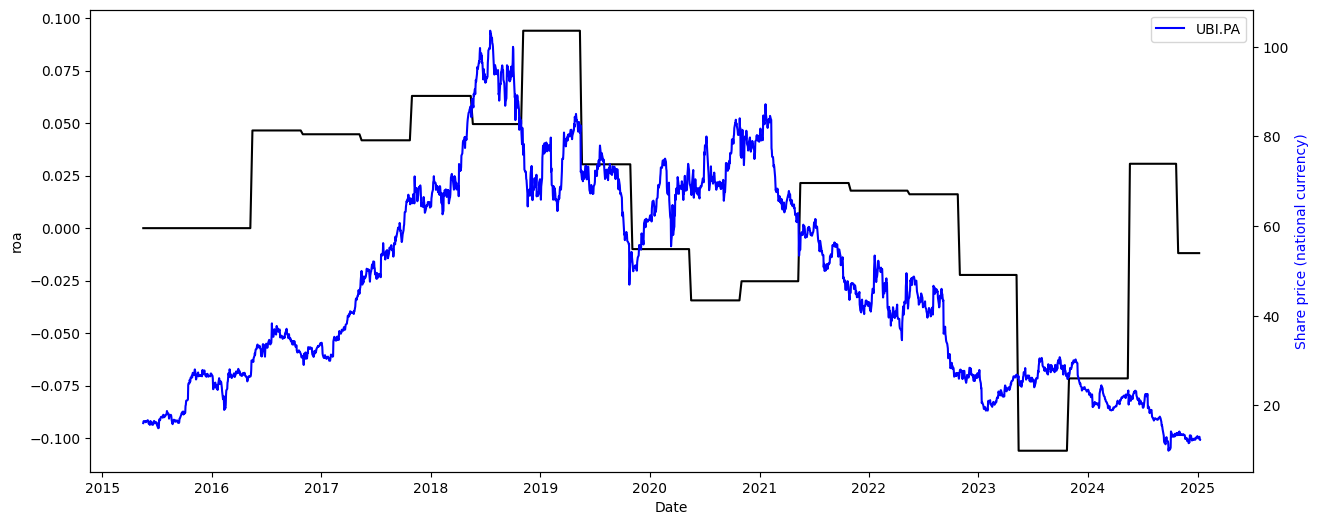

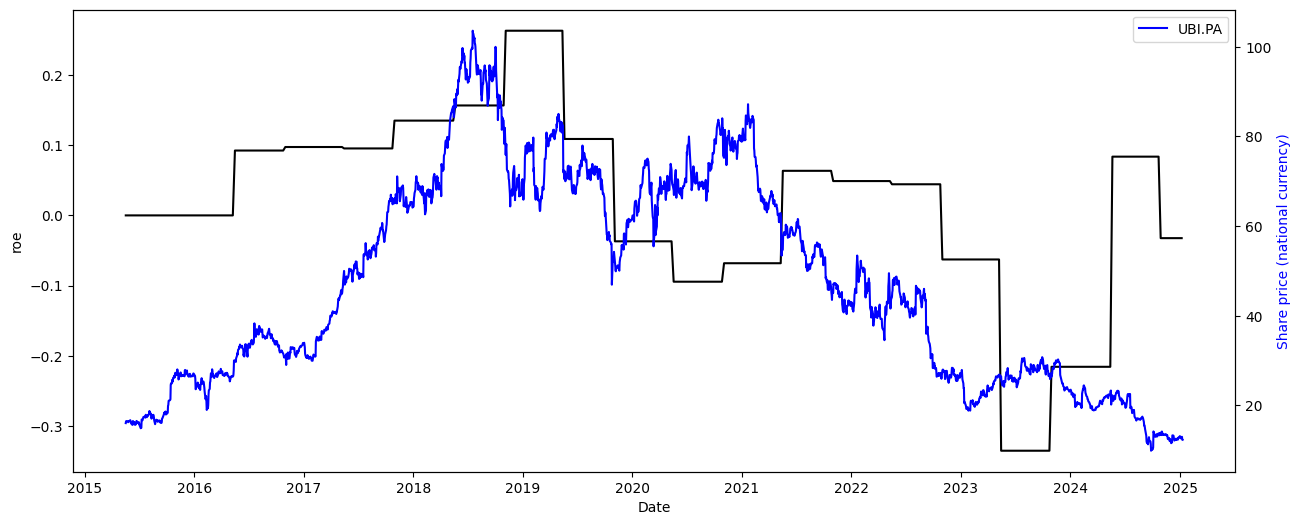

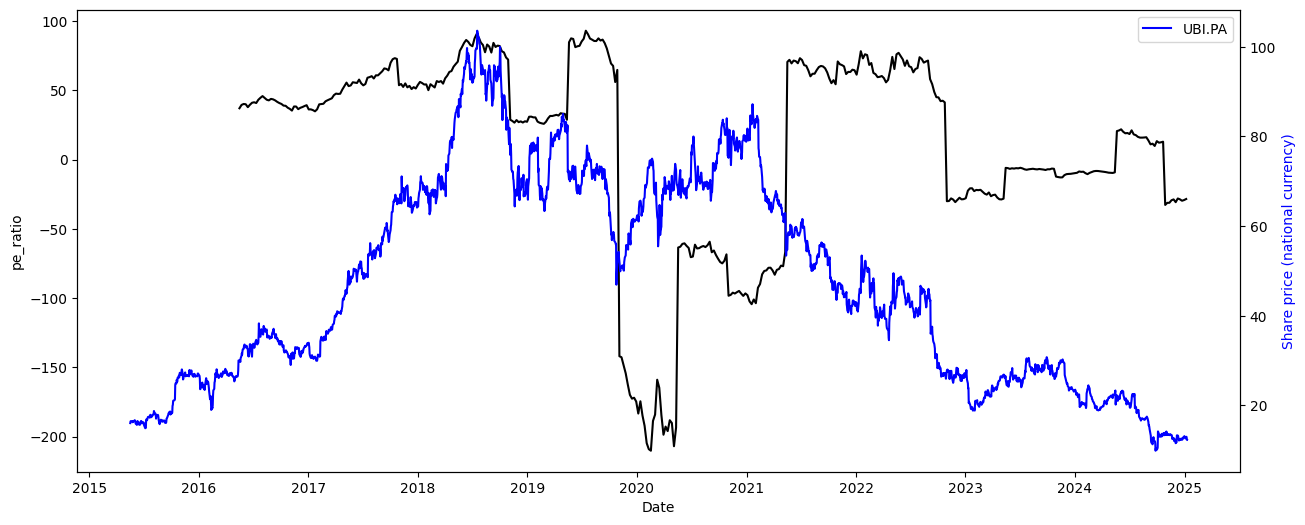

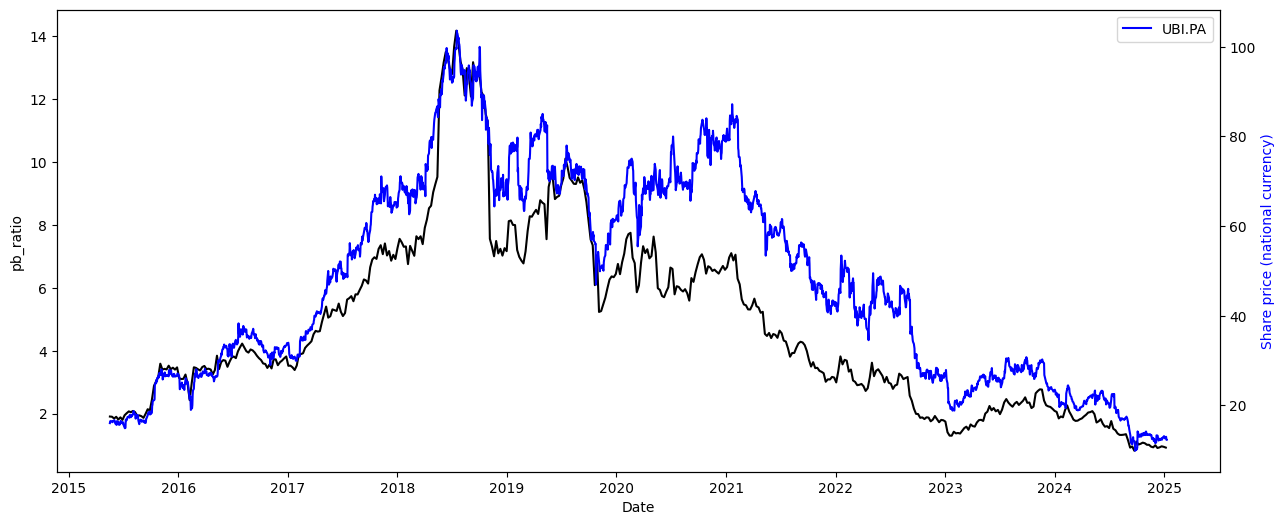

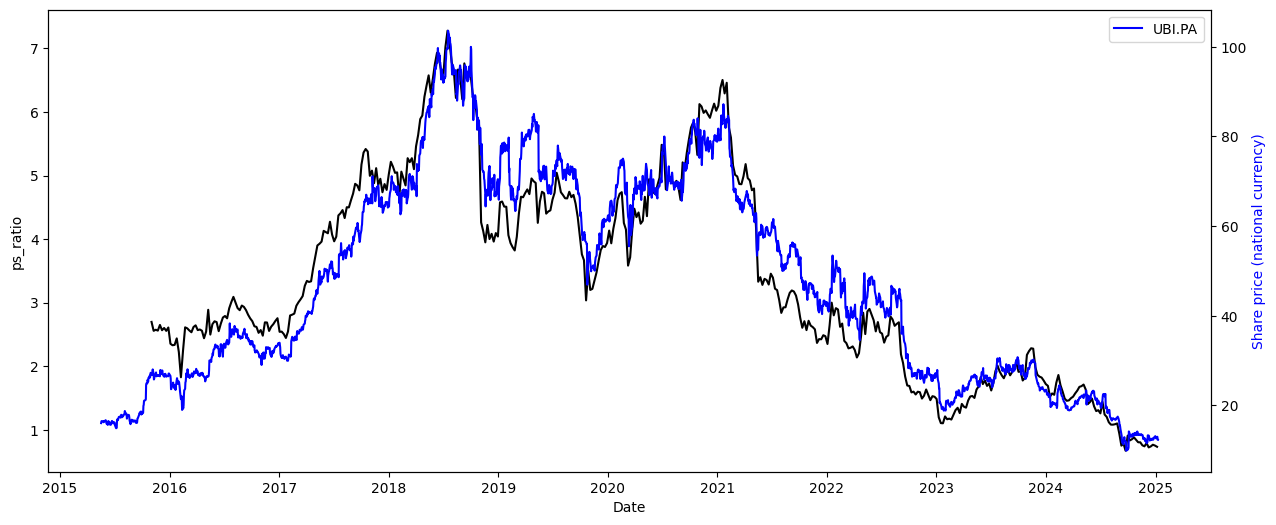

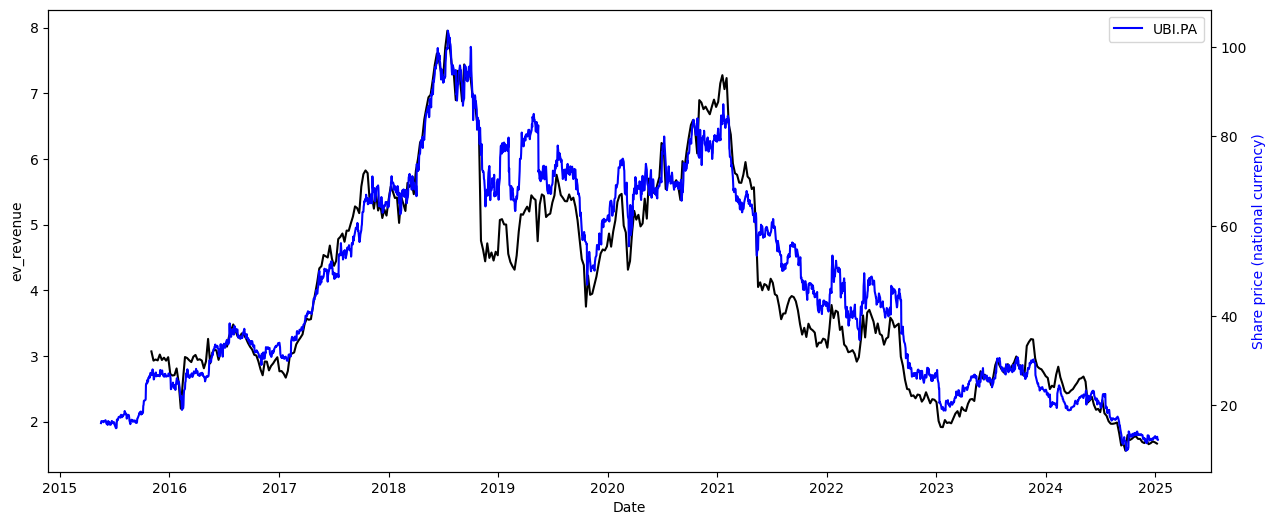

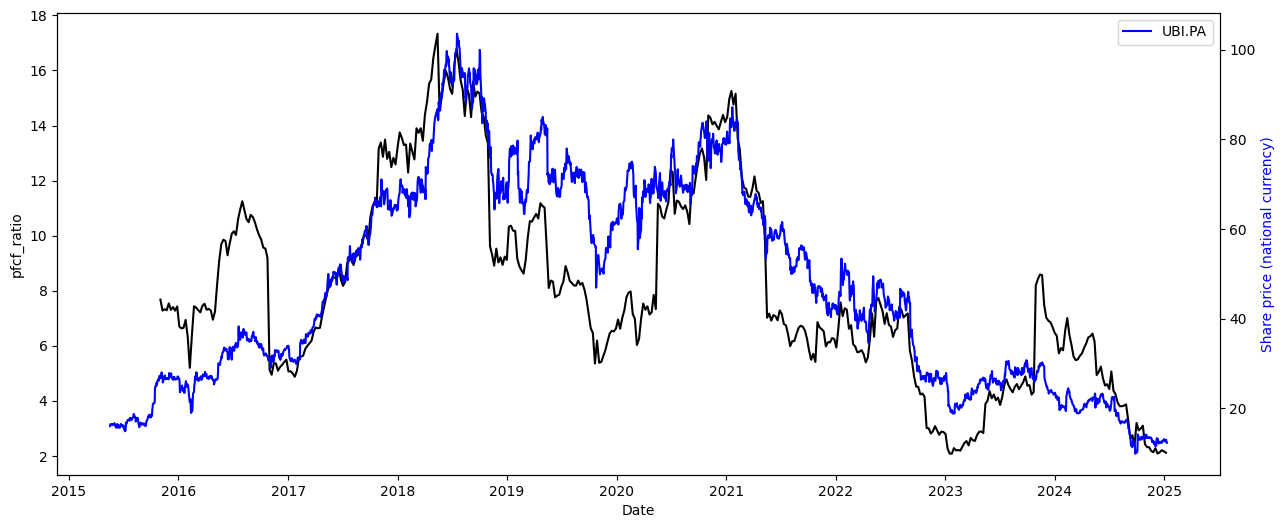

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

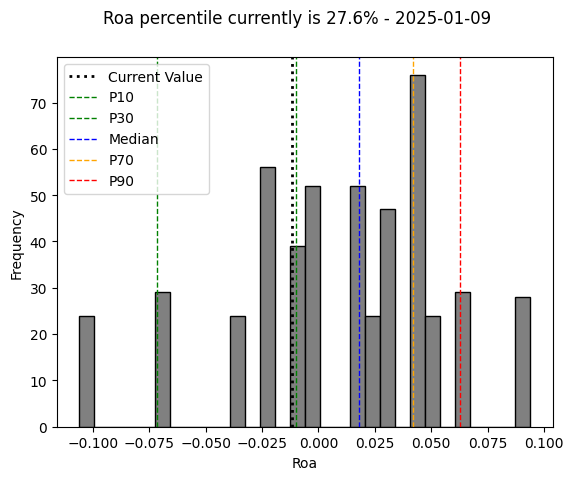

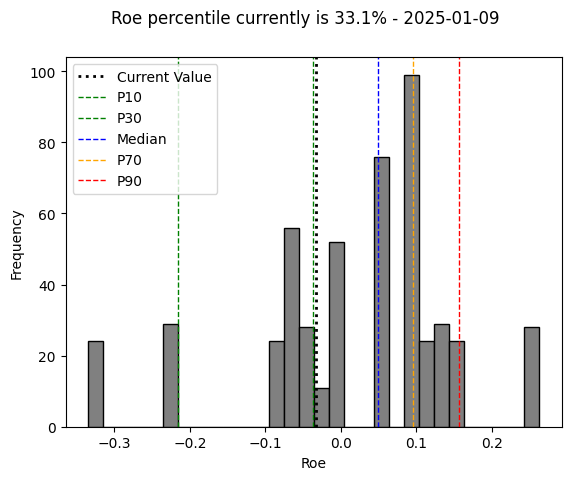

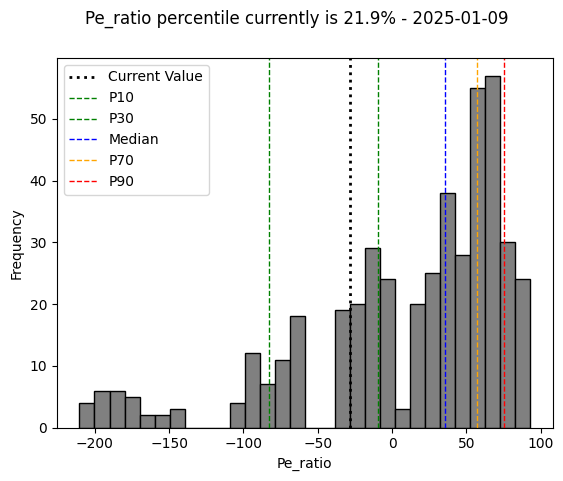

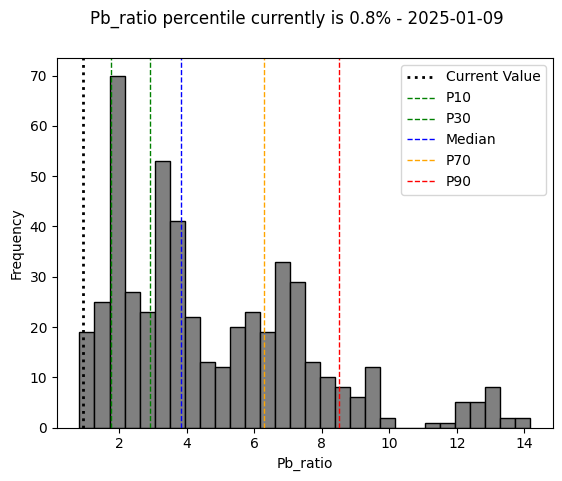

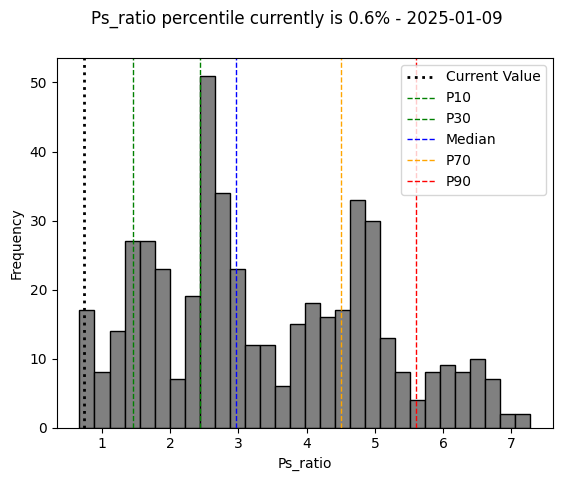

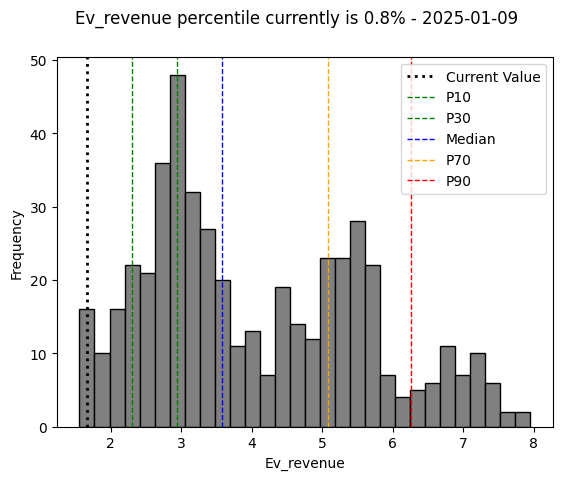

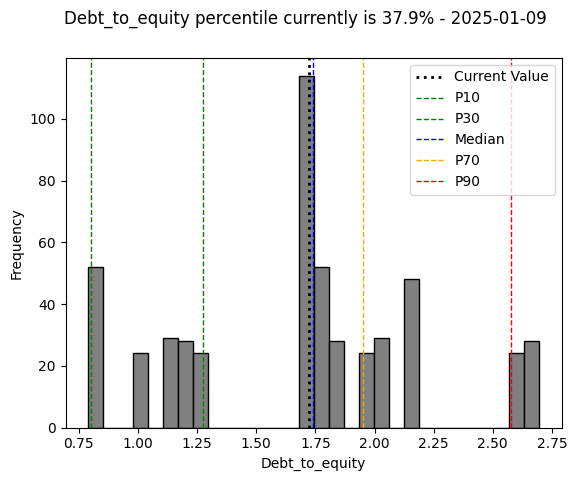

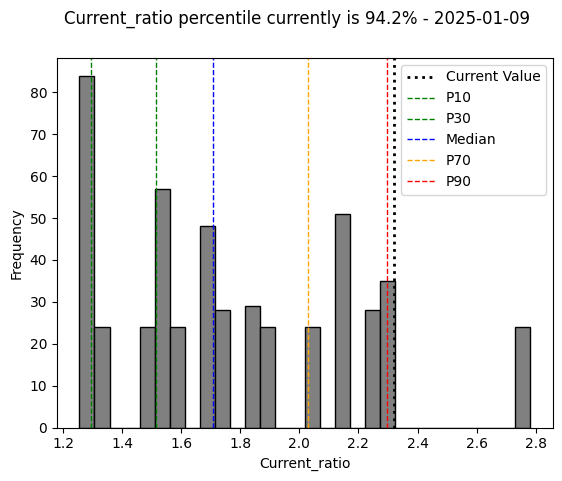

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.991324,0.506092,0.469438,0.370810,0.288345,-0.278562,-0.074178
roe,0.991324,1.000000,0.496528,0.495736,0.387363,0.314204,-0.222582,-0.120417
pe_ratio,0.506092,0.496528,1.000000,0.120418,-0.010232,-0.056132,-0.376694,0.319656
pb_ratio,0.469438,0.495736,0.120418,1.000000,0.922422,0.913846,0.299070,-0.252575
ps_ratio,0.370810,0.387363,-0.010232,0.922422,1.000000,0.990857,0.088098,-0.216584
ev_revenue,0.288345,0.314204,-0.056132,0.913846,0.990857,1.000000,0.189242,-0.212230
debt_to_equity,-0.278562,-0.222582,-0.376694,0.299070,0.088098,0.189242,1.000000,-0.078419
current_ratio,-0.074178,-0.120417,0.319656,-0.252575,-0.216584,-0.212230,-0.078419,1.000000


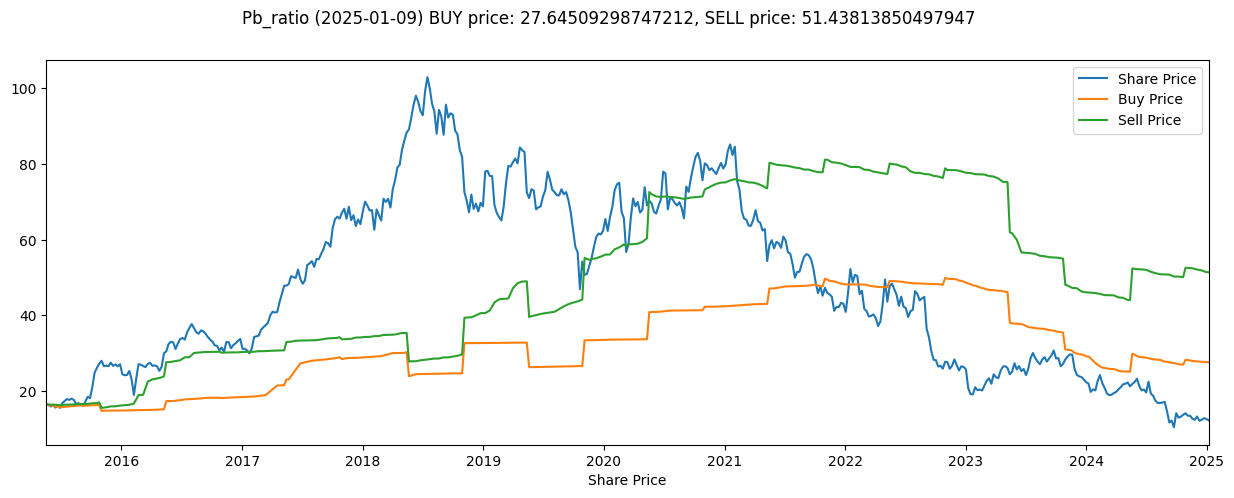

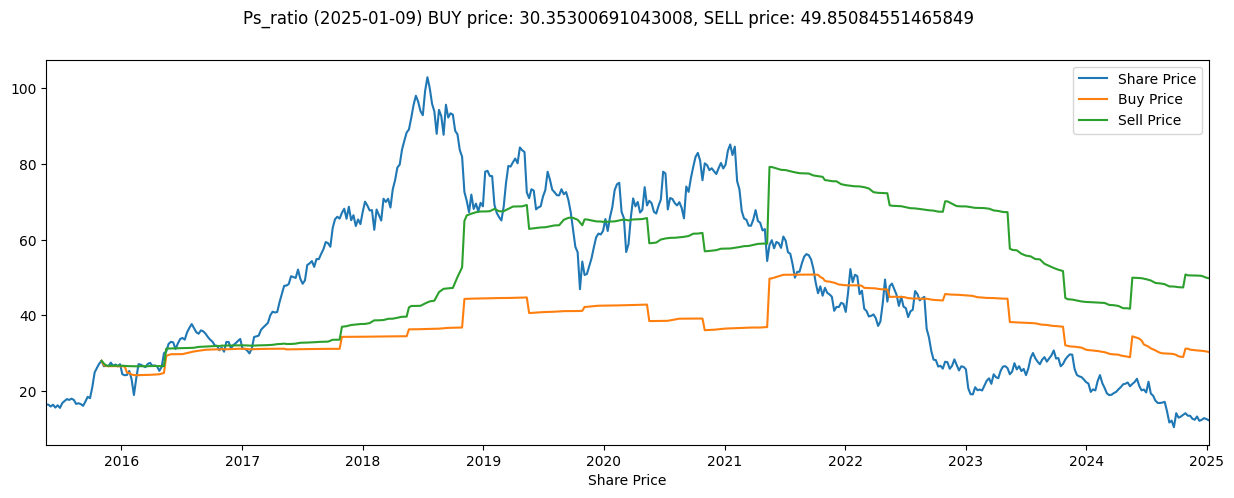

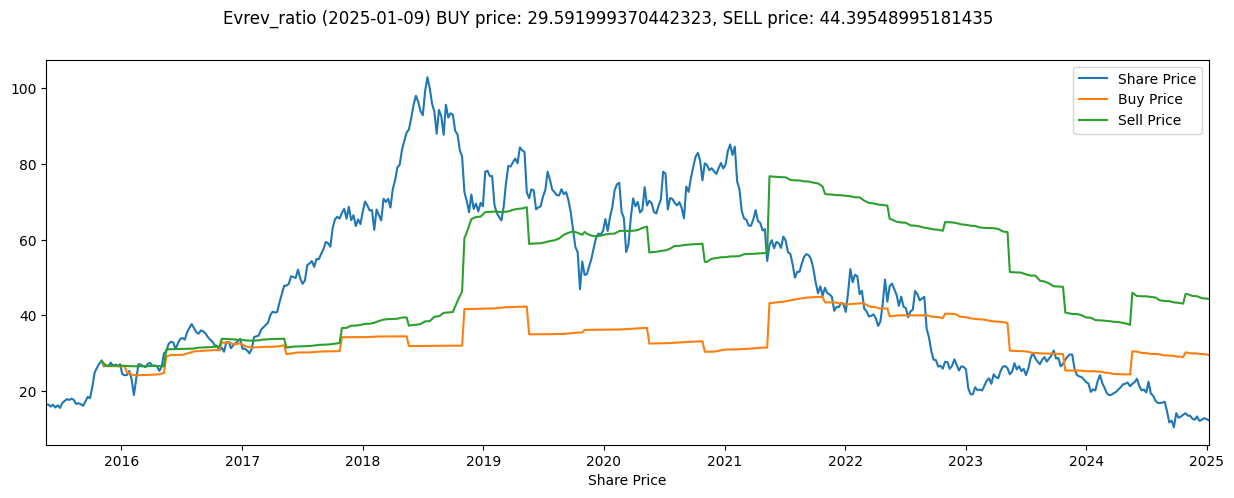

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)